In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from neuralhydrology.utils.config import Config

# load data

In [2]:
run_dir = Path("/datadrive/data/runs/kenya_nh_test")
run_dir = Path("/datadrive/data/runs/azure_nh_kenya_0306_201746")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

In [3]:
ds = xr.open_dataset(cfg.dynamic_nc_file)
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables: (12/15)
    VCI3M       (time, lat, lon) float64 ...
    boku_VCI    (time, lat, lon) float64 ...
    modis_ndvi  (time, lat, lon) float64 ...
    VCI         (time, lat, lon) float64 ...
    precip      (time, lat, lon) float64 ...
    E           (time, lat, lon) float64 ...
    ...          ...
    p84.162     (time, lat, lon) float64 ...
    pev         (time, lat, lon) float64 ...
    sp          (time, lat, lon) float64 ...
    t2m         (time, lat, lon) float64 ...
    tp          (time, lat, lon) float64 ...
    vci_lagged  (time, lat, lon) float64 ...

In [21]:
# print(dir(cfg))
# import pickle


# with open(cfg.run_dir / "train_data/train_data_scaler.p", "rb") as fp:
#     scaler = pickle.load(fp)
# scaler["xarray_feature_center"]

In [4]:
res_fp = get_test_filepath(run_dir, epoch=None)
preds = get_all_station_ds(res_fp)

100%|██████████| 1575/1575 [00:00<00:00, 2023.57it/s]


In [5]:
# load trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)
model

Using the model weights from /datadrive/data/runs/azure_nh_kenya_0306_201746/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): FC(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=30, bias=True)
        (1): Tanh()
        (2): Dropout(p=0.4, inplace=False)
        (3): Linear(in_features=30, out_features=5, bias=True)
      )
    )
  )
  (lstm): LSTM(5, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

# calculate errors

In [6]:
if "errors" not in globals():
    errors = calculate_all_error_metrics(preds, basin_coord="station_id", obs_var="boku_VCI_obs", sim_var="boku_VCI_sim")
else:
    print("Already run errors!")

Calculating Errors::   0%|          | 0/1575 [00:00<?, ?it/s, -0.25_33.75]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:464: RuntimeWarning: invalid value encountered in double_scalars
  fhv = np.sum(sim - obs) / np.sum(obs)
Calculating Errors::   0%|          | 0/1575 [00:00<?, ?it/s, -0.25_34.0] /home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:464: RuntimeWarning: invalid value encountered in double_scalars
  fhv = np.sum(sim - obs) / np.sum(obs)
Calculating Errors::   2%|▏         | 35/1575 [00:01<01:15, 20.45it/s, -0.5_33.75] /home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:464: RuntimeWarning: invalid value encountered in double_scalars
  fhv = np.sum(sim - obs) / np.sum(obs)
Calculating Errors::   4%|▍         | 70/1575 [00:03<01:16, 19.74it/s, -0.75_33.75]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:464: RuntimeWarning: invalid value encountered in double_scalars
  fhv = np.sum(sim - obs) / np.sum(obs)
Ca

In [7]:
preds["persistence"] = preds["boku_VCI_obs"].shift(date=1)

if "persistence_errors" not in globals():
    persistence_errors = calculate_all_error_metrics(preds, basin_coord="station_id", obs_var="boku_VCI_obs", sim_var="persistence")
else:
    print("Already run persistence errors!")

Calculating Errors::   0%|          | 0/1575 [00:00<?, ?it/s, -0.25_33.75]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:464: RuntimeWarning: invalid value encountered in double_scalars
  fhv = np.sum(sim - obs) / np.sum(obs)
Calculating Errors::   0%|          | 0/1575 [00:00<?, ?it/s, -0.25_34.0] /home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:464: RuntimeWarning: invalid value encountered in double_scalars
  fhv = np.sum(sim - obs) / np.sum(obs)
Calculating Errors::   2%|▏         | 35/1575 [00:01<01:15, 20.45it/s, -0.5_33.75] /home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:464: RuntimeWarning: invalid value encountered in double_scalars
  fhv = np.sum(sim - obs) / np.sum(obs)
Calculating Errors::   4%|▍         | 68/1575 [00:03<01:13, 20.48it/s, -0.75_33.75]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:464: RuntimeWarning: invalid value encountered in double_scalars
  fhv = np.sum(sim - obs) / np.sum(obs)
Ca

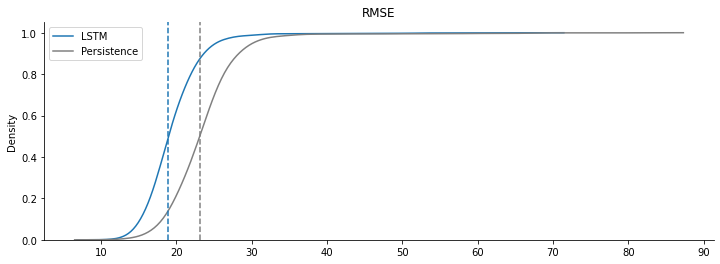

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

metric = "RMSE"
assert metric in [v for v in errors.data_vars], f"Expect one of: {[v for v in errors.data_vars]}"

da = errors[metric]  # .where(errors["NSE"] > 0)
pers = persistence_errors[metric]
f, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(da.values[np.isfinite(da)], cumulative=True, clip=(0, None), label="LSTM")
sns.kdeplot(pers.values[np.isfinite(pers)], cumulative=True, clip=(0, None), label="Persistence", color="grey")
ax.axvline(da.median(), ls="--", color="C0")
ax.axvline(pers.median(), ls="--", color="grey")
plt.legend()
ax.set_title(metric);
sns.despine()

In [9]:
def print_summaries(errors: xr.Dataset):
    print(f"Median NSE: \t{float((errors['NSE']).median().values):.2f}")
    print(f"Mean NSE: \t{float((errors['NSE']).mean().values):.2f}")
    print(f"Min NSE: \t{float((errors['NSE']).min().values):.2f}")
    print(f"Max NSE: \t{float((errors['NSE']).max().values):.2f}")
    print(f"P(Errors < 0): \t{(errors['NSE'] < 0).mean().values:.2f}")
    print("\n")

print_summaries(errors)
print_summaries(errors.where(errors["NSE"] > 0))

Median NSE: 	0.57
Mean NSE: 	-inf
Min NSE: 	-inf
Max NSE: 	0.88
P(Errors < 0): 	0.04


Median NSE: 	0.58
Mean NSE: 	0.55
Min NSE: 	0.00
Max NSE: 	0.88
P(Errors < 0): 	0.00




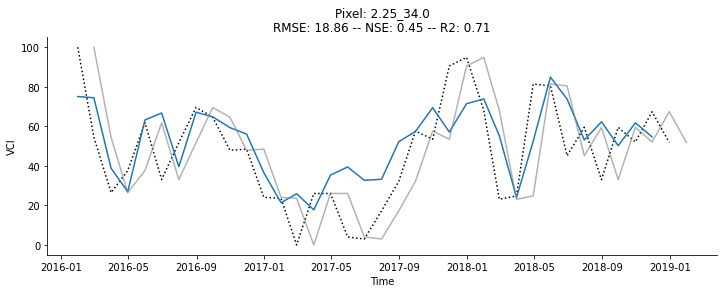

In [10]:
nonan = preds.dropna(dim="station_id", how="all")
pixel_str = np.random.choice(nonan.station_id.values)
pixel = nonan.sel(station_id=pixel_str)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(pixel.date, pixel["boku_VCI_obs"], color="k", ls=":")
ax.plot(pixel.date, pixel["boku_VCI_sim"])
ax.plot(pixel.date, pixel["persistence"], color="grey", alpha=0.6)
ax.set_xlabel("Time")
ax.set_ylabel("VCI")

error = errors.sel(station_id=pixel_str)
title = f"Pixel: {pixel_str}"
title += f"\nRMSE: {float(error['RMSE'].values):.2f} -- NSE: {float(error['NSE'].values):.2f} -- R2: {float(error['Pearson-r'].values):.2f}"
ax.set_title(title)
sns.despine()

In [11]:
errors

<xarray.Dataset>
Dimensions:      (station_id: 1432)
Coordinates:
  * station_id   (station_id) object '-0.25_33.75' '-0.25_34.0' ... '6.0_42.25'
Data variables:
    Alpha-NSE    (station_id) float64 0.5964 1.032 0.744 ... 0.6662 0.6928
    Beta-NSE     (station_id) float64 -0.4357 -1.124 0.681 ... -0.2951 -0.1008
    FHV          (station_id) float64 nan nan -14.43 ... -21.4 -20.23 -19.01
    FLV          (station_id) float64 92.59 57.81 93.26 ... 95.51 47.89 96.35
    FMS          (station_id) float64 -36.9 5.381e+07 -72.07 ... -38.3 -31.56
    KGE          (station_id) float64 -0.1843 -0.1724 0.05235 ... 0.576 0.5935
    MSE          (station_id) float64 1.982e+03 1.467e+03 870.2 ... 350.7 383.4
    NSE          (station_id) float64 -0.6631 -2.628 -0.5778 ... 0.4926 0.5359
    Peak-Timing  (station_id) float64 nan nan nan nan nan ... nan nan nan nan
    Pearson-r    (station_id) float64 -0.0986 -0.1453 0.2954 ... 0.7682 0.7405
    RMSE         (station_id) float64 44.52 38.3 29.5 ... 18.31 18.73 19.58